In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
####################################################
# Load the data
df = pd.read_csv("n/full_data_flightdelay.csv.xz", compression='xz')
# df = pd.read_csv("test.csv.xz", compression='xz')
#print(df.head())

# take a random sample of 1000 rows
df = df.sample(n=10000, random_state=42)

ontime = df[df['DEP_DEL15'] == 0]
delayed = df[df['DEP_DEL15'] == 1]

In [33]:
df.describe()

,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,...,PLANE_AGE,DEPARTING_AIRPORT,LATITUDE,LONGITUDE,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.634800,3.927900,0.193400,8.231900,3.843400,3.049100,27.765400,133.974900,9.111100,12640.642100,...,11.552000,42.881500,36.728235,-94.237052,154.376000,0.106784,0.028970,0.101060,71.490100,8.306849
std,3.413385,1.989296,0.394984,4.898584,2.381353,1.759318,21.403191,46.559062,5.129248,8810.857618,...,6.927185,27.093569,5.552612,17.871948,72.541372,0.343852,0.307371,0.779256,18.198885,3.605541
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,44.000000,0.000000,1100.000000,...,0.000000,0.000000,19.739000,-159.346000,0.000000,0.000000,0.000000,0.000000,-10.000000,0.450000
25%,4.000000,2.000000,0.000000,4.000000,2.000000,2.000000,11.000000,90.000000,5.000000,5337.000000,...,5.000000,17.000000,33.436000,-106.377000,99.000000,0.000000,0.000000,0.000000,59.000000,5.820000
50%,7.000000,4.000000,0.000000,8.000000,3.000000,3.000000,23.000000,143.000000,10.000000,11588.000000,...,12.000000,42.000000,37.363000,-87.906000,182.000000,0.000000,0.000000,0.000000,74.000000,7.830000
75%,10.000000,6.000000,0.000000,12.000000,5.000000,4.000000,39.000000,172.000000,14.000000,17522.000000,...,17.000000,66.000000,40.779000,-80.936000,203.000000,0.030000,0.000000,0.000000,86.000000,10.290000
max,12.000000,7.000000,1.000000,18.000000,11.000000,13.000000,108.000000,337.000000,16.000000,35256.000000,...,32.000000,94.000000,61.169000,-70.304000,291.000000,11.630000,9.900000,18.900000,115.000000,33.780000


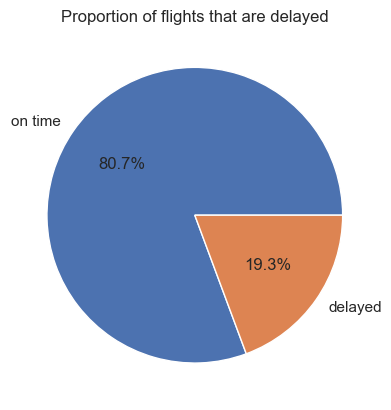

In [17]:
plt.pie(df['DEP_DEL15'].value_counts(), labels=['on time', 'delayed'], autopct='%1.1f%%')
plt.title('Proportion of flights that are delayed')
plt.show()

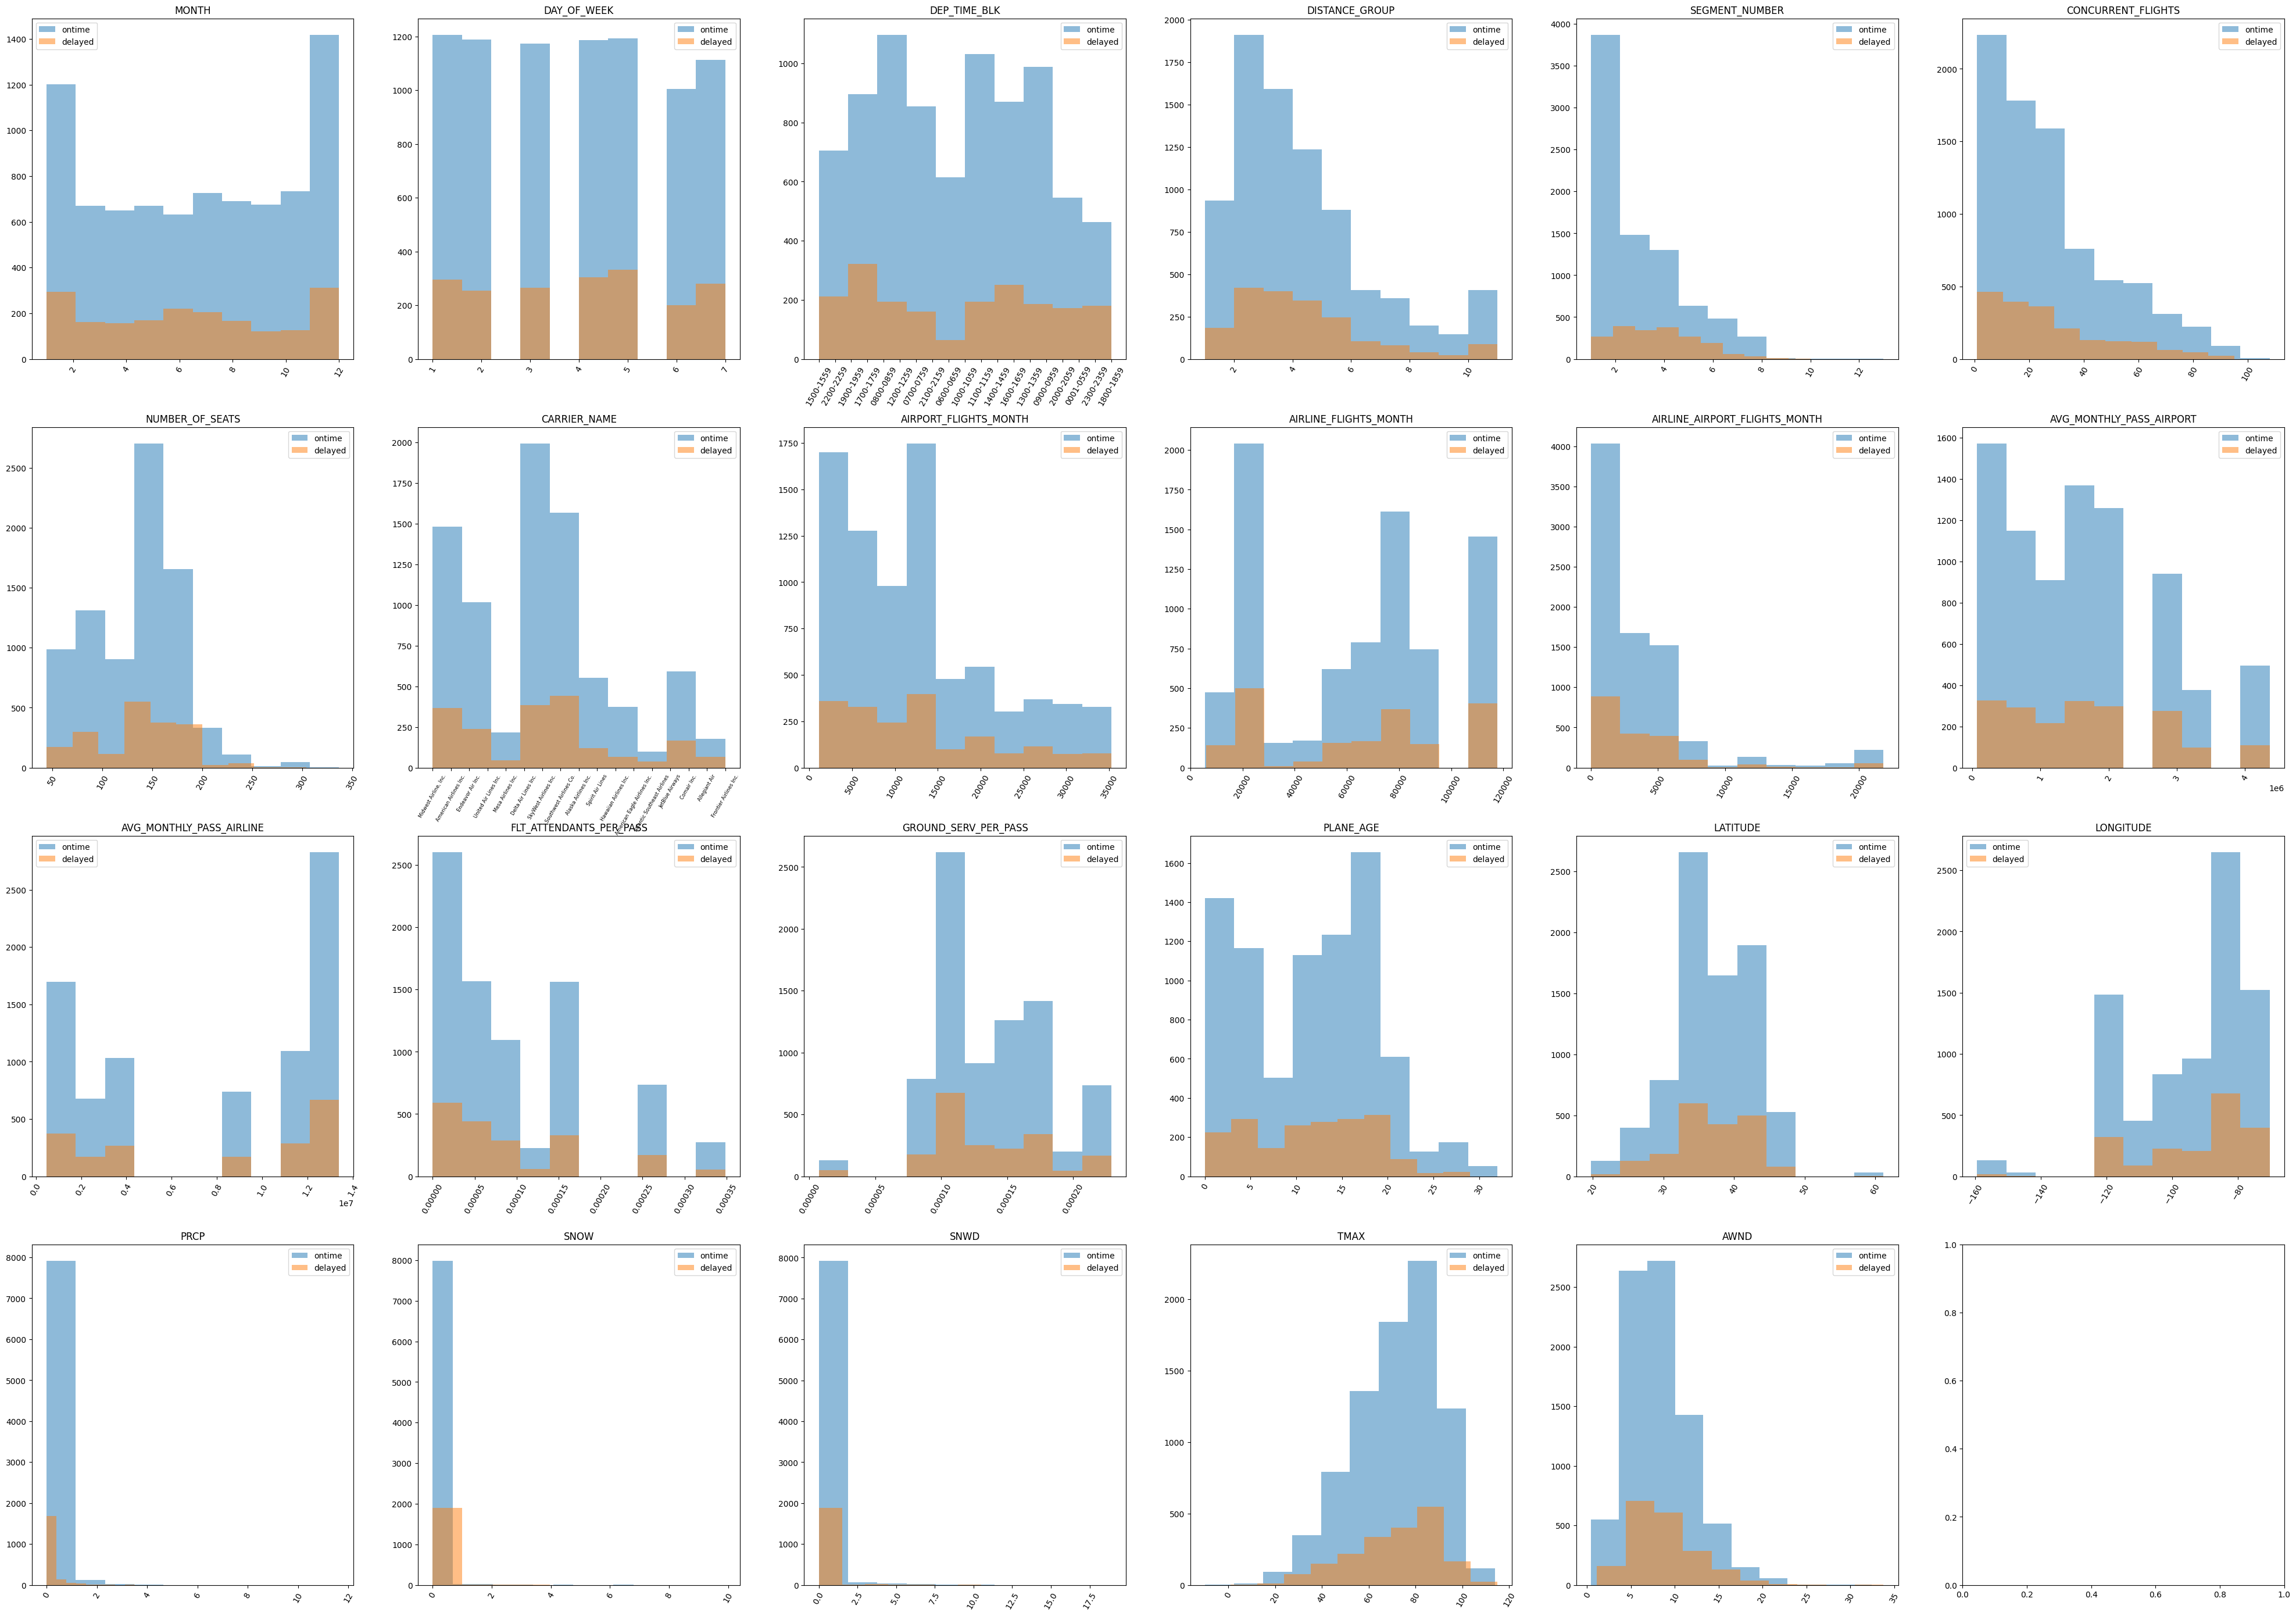

In [ ]:
# Inital EDA
# Plot the columns of the ontime and delayed flights and compare, put all the plots in the same figure
# Create a figure with 5 rows and 6 columns which are well spaced

plot_ontime = ontime.copy()
plot_delayed = delayed.copy()

plot_ontime = plot_ontime.drop(columns=['DEP_DEL15', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT'])
plot_delayed = plot_delayed.drop(columns=['DEP_DEL15', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT'])
sns.reset_defaults()

fig, axs = plt.subplots(4, 6, figsize=(50, 35))

for i, col in enumerate(plot_ontime.columns):
    ax = axs[i//6, i%6]
    
    ax.hist(plot_ontime[col], alpha=0.5, label='ontime')
    ax.hist(plot_delayed[col], alpha=0.5, label='delayed')
    ax.tick_params(axis='x', rotation=60)
    if col == 'CARRIER_NAME':
        ax.tick_params(axis='x', rotation=60, labelsize=6)
    ax.set_title(col)
    ax.legend()
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
# plt.savefig('flights.png')
plt.show()

In [40]:
# Print airports with the most delayed flights
delayed_airports = delayed['DEPARTING_AIRPORT'].value_counts()
delayed_airports = delayed_airports.sort_values(ascending=False)
delayed_airports

DEPARTING_AIRPORT
Atlanta Municipal                 109
Stapleton International           108
Chicago O'Hare International       97
Dallas Fort Worth Regional         96
Douglas Municipal                  74
                                 ... 
Northwest Arkansas Regional         1
Portland International Jetport      1
Sanford NAS                         1
Pensacola Regional                  1
Albany International                1
Name: count, Length: 95, dtype: int64

In [30]:
# Print airlines with the most delayed flights

delayed_airlines = delayed['CARRIER_NAME'].value_counts()
delayed_airlines = delayed_airlines.sort_values(ascending=False)
print(delayed_airlines)

CARRIER_NAME
Southwest Airlines Co.          443
American Airlines Inc.          287
Delta Air Lines Inc.            224
United Air Lines Inc.           169
SkyWest Airlines Inc.           161
JetBlue Airways                 105
Midwest Airline, Inc.            80
Endeavor Air Inc.                70
Spirit Air Lines                 68
Comair Inc.                      63
American Eagle Airlines Inc.     56
Alaska Airlines Inc.             52
Frontier Airlines Inc.           51
Mesa Airlines Inc.               44
Atlantic Southeast Airlines      37
Allegiant Air                    14
Hawaiian Airlines Inc.           10
Name: count, dtype: int64


In [6]:
# DATA CLEANING
# encode the categorical data
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df

# clean the labels
list_of_labels = ['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DEP_TIME_BLK']
df = clean_labels_encoder(list_of_labels, df)

# Drop the columns that are not needed
# df = df.drop(['CARRIER_HISTORICAL', 'DEP_AIRPORT_HIST', 'DAY_HISTORICAL',
#        'DEP_BLOCK_HIST'], axis=1)

# Fill the missing values
df.fillna(df.mean(), inplace=True)

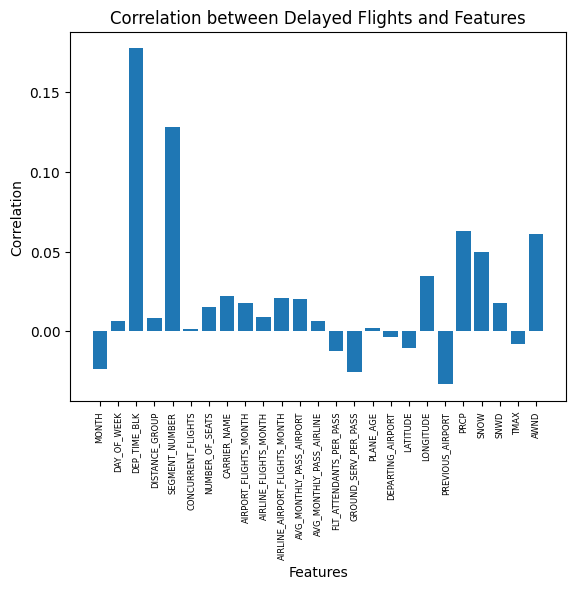

DEP_TIME_BLK                     0.177524
SEGMENT_NUMBER                   0.128238
PRCP                             0.063010
AWND                             0.061020
SNOW                             0.049403
LONGITUDE                        0.034331
CARRIER_NAME                     0.021875
AIRLINE_AIRPORT_FLIGHTS_MONTH    0.020732
AVG_MONTHLY_PASS_AIRPORT         0.019968
SNWD                             0.017757
AIRPORT_FLIGHTS_MONTH            0.017531
NUMBER_OF_SEATS                  0.015013
AIRLINE_FLIGHTS_MONTH            0.009012
DISTANCE_GROUP                   0.008066
DAY_OF_WEEK                      0.006293
AVG_MONTHLY_PASS_AIRLINE         0.006058
PLANE_AGE                        0.002282
CONCURRENT_FLIGHTS               0.001464
DEPARTING_AIRPORT               -0.003437
TMAX                            -0.007789
LATITUDE                        -0.010527
FLT_ATTENDANTS_PER_PASS         -0.012385
MONTH                           -0.024012
GROUND_SERV_PER_PASS            -0

In [7]:
# FEATURE ENGINEERING
# Calculate the correlation between DEP_DEL15 and the other columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation = df[numeric_cols].corr()['DEP_DEL15']
correlation = correlation.drop(['DEP_DEL15'])


#print(correlation)

# Plot the correlation
plt.bar(correlation.index, correlation)
plt.xticks(rotation=90)
plt.tick_params(axis='x', rotation=90, labelsize=6)
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.title("Correlation between Delayed Flights and Features")
plt.show()


# Sort the correlation
correlation = correlation.sort_values(ascending=False)
print(correlation)

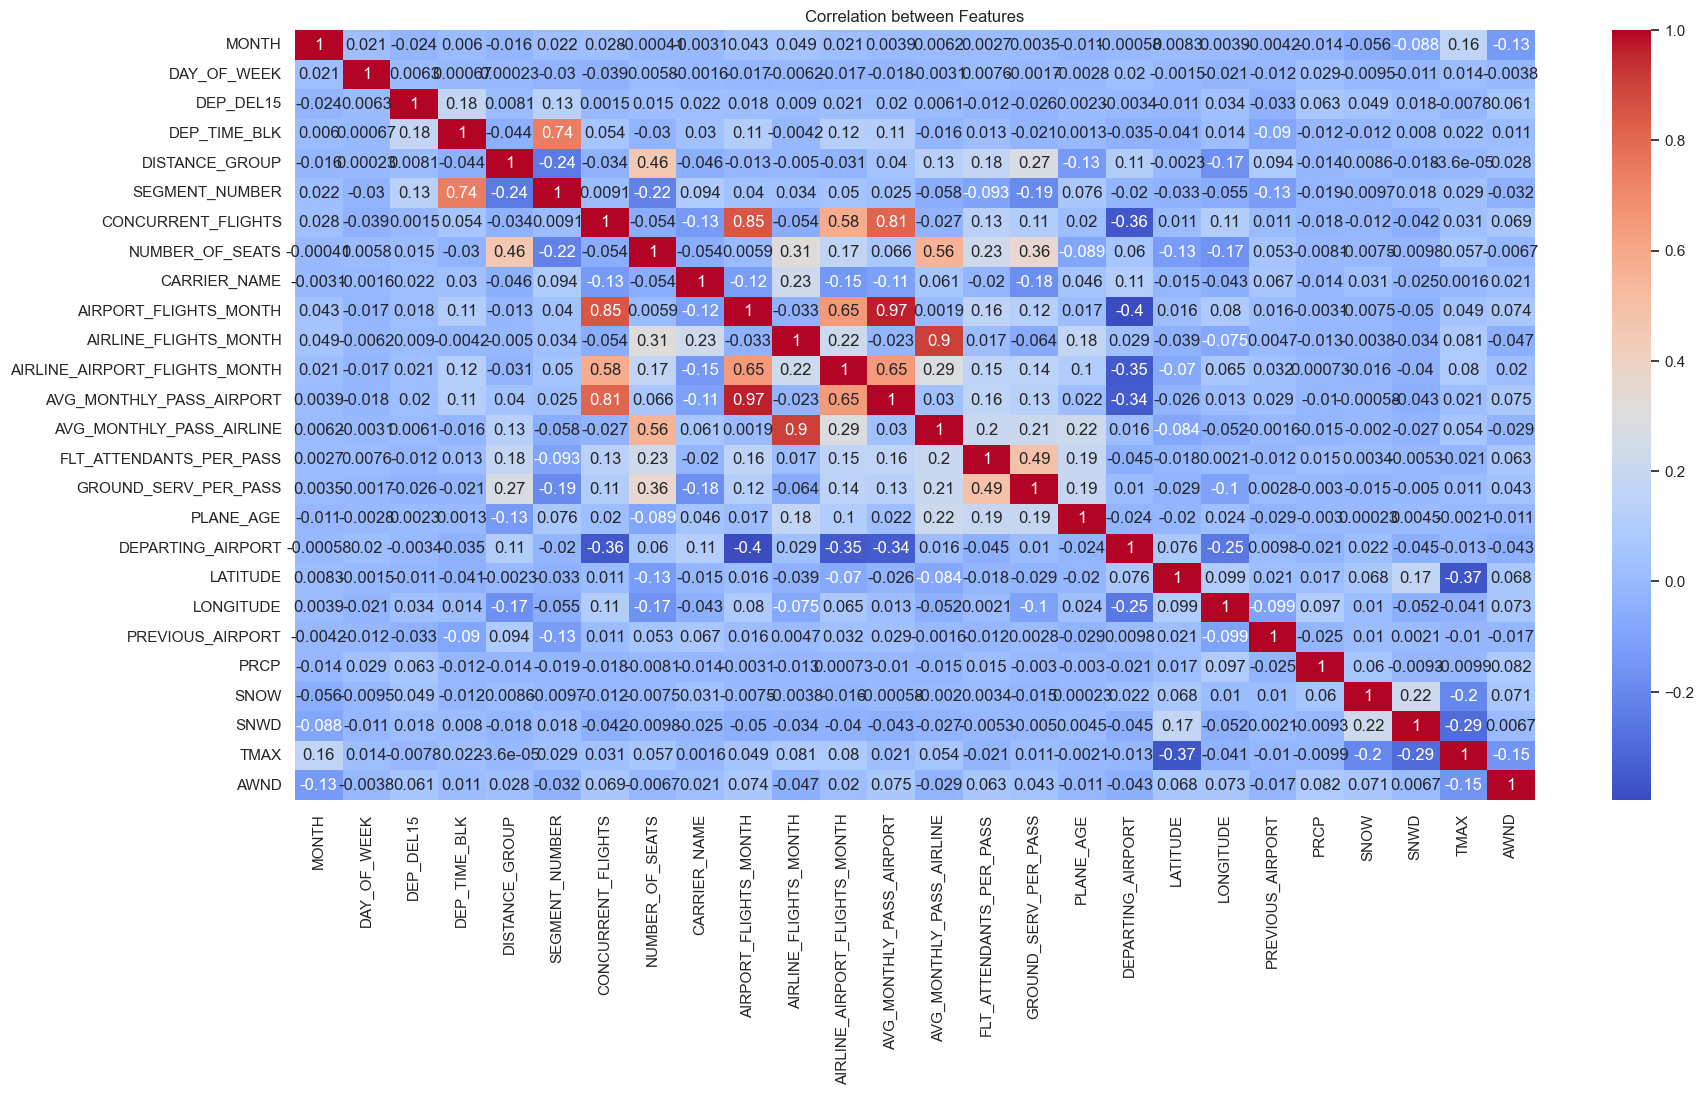

In [8]:
def plot_heatmap(df):
    plt.figure(figsize=(20, 10))
    sns.set_theme(style='whitegrid', context='notebook')
    cols = [0, 1, 2]
    sns.heatmap(df.corr(), annot=True, square=False, cmap='coolwarm')
    plt.title('Correlation between Features')
    plt.show()

plot_heatmap(df)

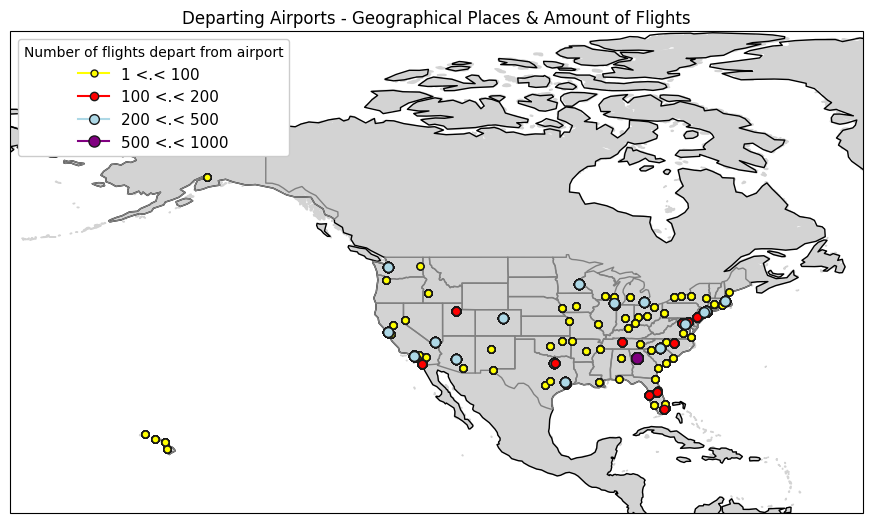

In [39]:
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, STATES
from collections import OrderedDict
airports = df[['LONGITUDE', 'LATITUDE', 'DEPARTING_AIRPORT']]

count_flights = df["DEPARTING_AIRPORT"].value_counts()

plt.figure(figsize=(11, 11))
ax = plt.axes(projection=ccrs.PlateCarree())

# Define properties of markers and labels
colors = ['yellow', 'red', 'lightblue', 'purple']
size_limits = [1, 100, 200, 500, 1000, 2000, 5000]
labels = []

# Generate labels for legend
for i in range(len(size_limits) - 1):
    label = f"{size_limits[i]} <.< {size_limits[i+1]}"
    labels.append(label)

# Add map features
ax.add_feature(NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'))
ax.coastlines()
ax.add_feature(STATES, edgecolor='gray')
ax.set_extent([-180, -50, 10, 75])

# Plot airports on map
for index, row in airports.iterrows():
    flight_count = count_flights[row['DEPARTING_AIRPORT']]
    isize = []
    for i, val in enumerate(size_limits):
        if val < flight_count:
            isize.append(i)
    ind = isize[-1] if isize else 0  # default to smallest if no flights
    ax.plot(row['LONGITUDE'], row['LATITUDE'], marker='o', markersize=ind + 5, color=colors[ind],
            markeredgewidth=1, markeredgecolor='k', transform=ccrs.Geodetic(), label=labels[ind])

# Remove duplicate labels and set their order
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = [f"{size_limits[i]} <.< {size_limits[i+1]}" for i in range(len(size_limits) - 1)]
new_label = OrderedDict((key, by_label[key]) for key in key_order if key in by_label)
plt.title("Departing Airports - Geographical Places & Amount of Flights")
plt.legend(new_label.values(), new_label.keys(), loc='upper left', prop={'size': 11},
           title='Number of flights depart from airport', frameon=True, framealpha=1)

plt.show()

In [53]:
month_to_season = {
    1: 'winter',
    2: 'winter',
    3: 'spring',
    4: 'spring',
    5: 'spring',
    6: 'summer',
    7: 'summer',
    8: 'summer',
    9: 'fall',
    10: 'fall',
    11: 'fall',
    12: 'winter'
}

df['SEASON'] = df['MONTH'].map(month_to_season)
values = df['SEASON'].value_counts()
values

# Calaculate the percentage of delayed flights in each season
seasons = df['SEASON'].unique()
percentages = []
for season in seasons:
    total_flights = df[df['SEASON'] == season].shape[0]
    delayed_flights = df[(df['SEASON'] == season) & (df['DEP_DEL15'] == 1)].shape[0]
    percentage = (delayed_flights / total_flights) * 100
    percentages.append(percentage)
print(seasons)
percentages

['spring' 'fall' 'winter' 'summer']


[19.70125151392814, 14.83406637345062, 20.285594288114236, 22.415751609238924]